# Lorenz attractor

Consider the Lorenz attractor, a 3-D system defined by the equations

\begin{eqnarray*}
\dot{x} & = & \sigma(y-x)\\
\dot{y} & = & x(\rho-z)-y\\
\dot{z} & = & xy-\beta z
\end{eqnarray*}

See the [Wikipedia page](http://en.wikipedia.org/wiki/Lorenz_system) for a discussion. Here, all right-hand sides are multiplied by a factor $\omega$ to adjust the speed. For visualisation, the system is orthogonally projected onto the plane containing the $z$-axis and the axis making an angle $\theta$ with the $x$-axis in the $xy$-plane, where $\theta$ is a parameter which can be modified during the simulation.

Documentation: [here](../doc/_build/html/odesimu.html)

In [1]:
%pylab nbagg
# for better display performance, use default backend

import logging
logger = logging.getLogger()

from functools import partial
from ipyshow.odesimu.system import System
from ipyshow.odesimu.util import logger_hook

Populating the interactive namespace from numpy and matplotlib


## LorenzAttractor class

In [2]:
#----------------------------------------------------------------------------------------------------
class LorenzAttractor (System):
#----------------------------------------------------------------------------------------------------

    shadowshape = (3,)

    def __init__(self,sigma,rho,beta,omega):
        """
:param sigma,rho,beta: parameters of the equation in s^-1
        """
        def main(t,state):
            x,y,z = state
            return omega*array((sigma*(y-x),x*(rho-z)-y,x*y-beta*z))
        self.main = main
        def jac(t,state):
            x,y,z = state
            return omega*array(((-sigma,sigma,0),(rho-z,-1,-x),(y,x,-beta)))
        self.jacobian = jac
        def fordisplay(state): return state,state
        self.fordisplay = fordisplay

    def display(self,ax,ini=None,**ka):
        from matplotlib.patches import Ellipse, Arrow
        from matplotlib.transforms import Affine2D
        ax.set_title(r'trajectory:?')
        diag_s = ax.scatter((),(),marker='o',c='b')
        tail_l, = ax.plot((),(),c='y')
        rmov = None
        def rotate_on(ev,delta=pi/100):
            nonlocal rmov
            if ev.key == 'right': rmov = delta
            elif ev.key == 'left': rmov = -delta
            else: return
        def rotate_off(ev):
            nonlocal rmov
            if ev.key=='right' or ev.key=='left': rmov = None
        ax.figure.canvas.mpl_connect('key_press_event',rotate_on)
        ax.figure.canvas.mpl_connect('key_release_event',rotate_off)
        # naive projection, no perspective
        theta,rcos,rsin = 0.,1.,0.
        rot = lambda x,y: x*rcos+y*rsin
        def slant(theta=0): return Affine2D().rotate(theta).scale(sx=1.,sy=.6).translate(.95,.05)+ax.transAxes
        ax.add_patch(Ellipse(xy=(.95,.05),width=.06,height=.04,fill=False,ec='k',alpha=.4,transform=ax.transAxes))
        arrow = ax.add_patch(Arrow(0.,0.,.03,0,lw=1,width=.01,ec='k',alpha=.4,transform=slant()))
        ax.add_patch(Arrow(.95,.05,0,.05,lw=1,width=.01,ec='k',transform=ax.transAxes))
        def disp(t,live,tail):
            nonlocal theta, rcos, rsin
            if rmov is not None: theta += rmov; rcos,rsin = cos(theta),sin(theta); arrow.set_transform(slant(theta))
            x,y,z = live
            diag_s.set_offsets(((rot(x,y),z),))
            tail_l.set_data(rot(tail[:,0],tail[:,1]),tail[:,2])
            ax.relim()
            ax.autoscale_view()
        return super(LorenzAttractor,self).display(ax,disp,ini=ini,**ka)

    @staticmethod
    def makestate(x=0,y=0,z=0): return array((x,y,z))

    launchdefaults = dict(
        maxtime=infty,
        srate=25.,
        taild=60,
        hooks=(partial(logger_hook,logger=logger),),
        animate=dict(repeat=False,),
    )

Launcher
--------

System parameters:

* `sigma`,`beta`,`rho`: neutral
* `omega`: in sec$^{-1}$

Launch parameters:

* `ini/x,y,z`: neutral
* `srate`: simulation rate (in frames.sec$^{-1}$)
* `taild`: duration of shadow, ie. trace of previous states (in sec)
* `hooks`: list of display hooks (see doc)

The rotation angle $\theta$ for the visualisation is reflected in an ellipse at the bottom right corner of the figure, and can be modified using the arrow keys of the keyboard: "right" to increase $\theta$ (turns the projection plane anti-clockwise) and "left" to decrease $\theta$ (turns the projection plane clockwise). Maybe it is the other way round :-)

<IPython.core.display.Javascript object>


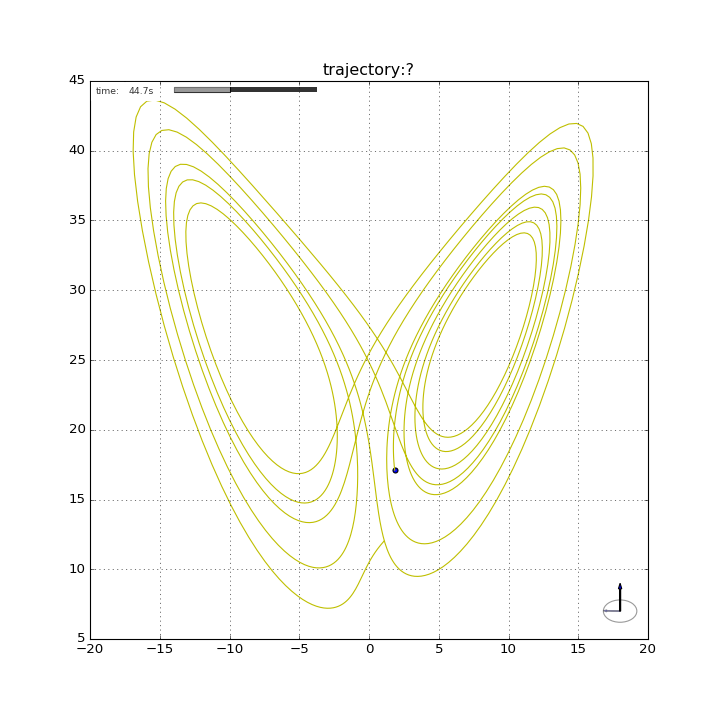

In [3]:
logger.setLevel(logging.WARN) # can be changed dynamically by logger_hook
syst = LorenzAttractor(sigma=10,rho=28,beta=8/3,omega=.2); ini=dict(x=-1,y=2,z=12)
syst.launch(ini=syst.makestate(**ini))